
## Name: Ofir Haim.

In [ ]:
# Extracting our dataset from the Zip file
from zipfile import ZipFile
file_name = "diamonds.csv.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()


In [ ]:
# All the imports we'll need for the project
import torch
import torch.nn as nn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import cross_val_score



# Data Preprocessing

In [ ]:
# Reading Data
df = pd.read_csv("/content/diamonds.csv")
# Removing unnecessary Column
df = df.drop(["Unnamed: 0"], axis=1)
df.describe()

carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.250000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53940.000000  53940.000000  
mean       5.734526      3.538734  
std        1.142135      0.705699  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.040000  
max       58.900000     31.800000

In [ ]:
# Printing info about our dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [ ]:
# Creating Copy so That data can be reprocessed later
dfCopy = df.copy()

# We'll now check to see whether there are 0 values in the "x", "y" or "z" Columns.
xMin = dfCopy["x"].min()
yMin = dfCopy["y"].min()
zMin = dfCopy["z"].min()
print(f"Min X:  {xMin} Min Y: {yMin} Min Z: {zMin}")

# Since there are such values, we will remove them from our data - those are diamonds that are less than 3 dimentions
dfCopy = dfCopy.drop(dfCopy[dfCopy["x"]==0].index)
dfCopy = dfCopy.drop(dfCopy[dfCopy["y"]==0].index)
dfCopy = dfCopy.drop(dfCopy[dfCopy["z"]==0].index)
dfCopy = pd.get_dummies(dfCopy,drop_first=True)
dfCopy.head()

Min X:  0.0 Min Y: 0.0 Min Z: 0.0


carat  depth  table  price     x     y     z  cut_Good  cut_Ideal  \
0   0.23   61.5   55.0    326  3.95  3.98  2.43         0          1   
1   0.21   59.8   61.0    326  3.89  3.84  2.31         0          0   
2   0.23   56.9   65.0    327  4.05  4.07  2.31         1          0   
3   0.29   62.4   58.0    334  4.20  4.23  2.63         0          0   
4   0.31   63.3   58.0    335  4.34  4.35  2.75         1          0   

   cut_Premium  ...  color_H  color_I  color_J  clarity_IF  clarity_SI1  \
0            0  ...        0        0        0           0            0   
1            1  ...        0        0        0           0            1   
2            0  ...        0        0        0           0            0   
3            1  ...        0        1        0           0            0   
4            0  ...        0        0        1           0            0   

   clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  clarity_VVS2  
0            1            0            0             0             0  
1            0            0            0             0             0  
2            0            1            0             0             0  
3            0            0            1             0             0  
4            1            0            0             0             0  

[5 rows x 24 columns]

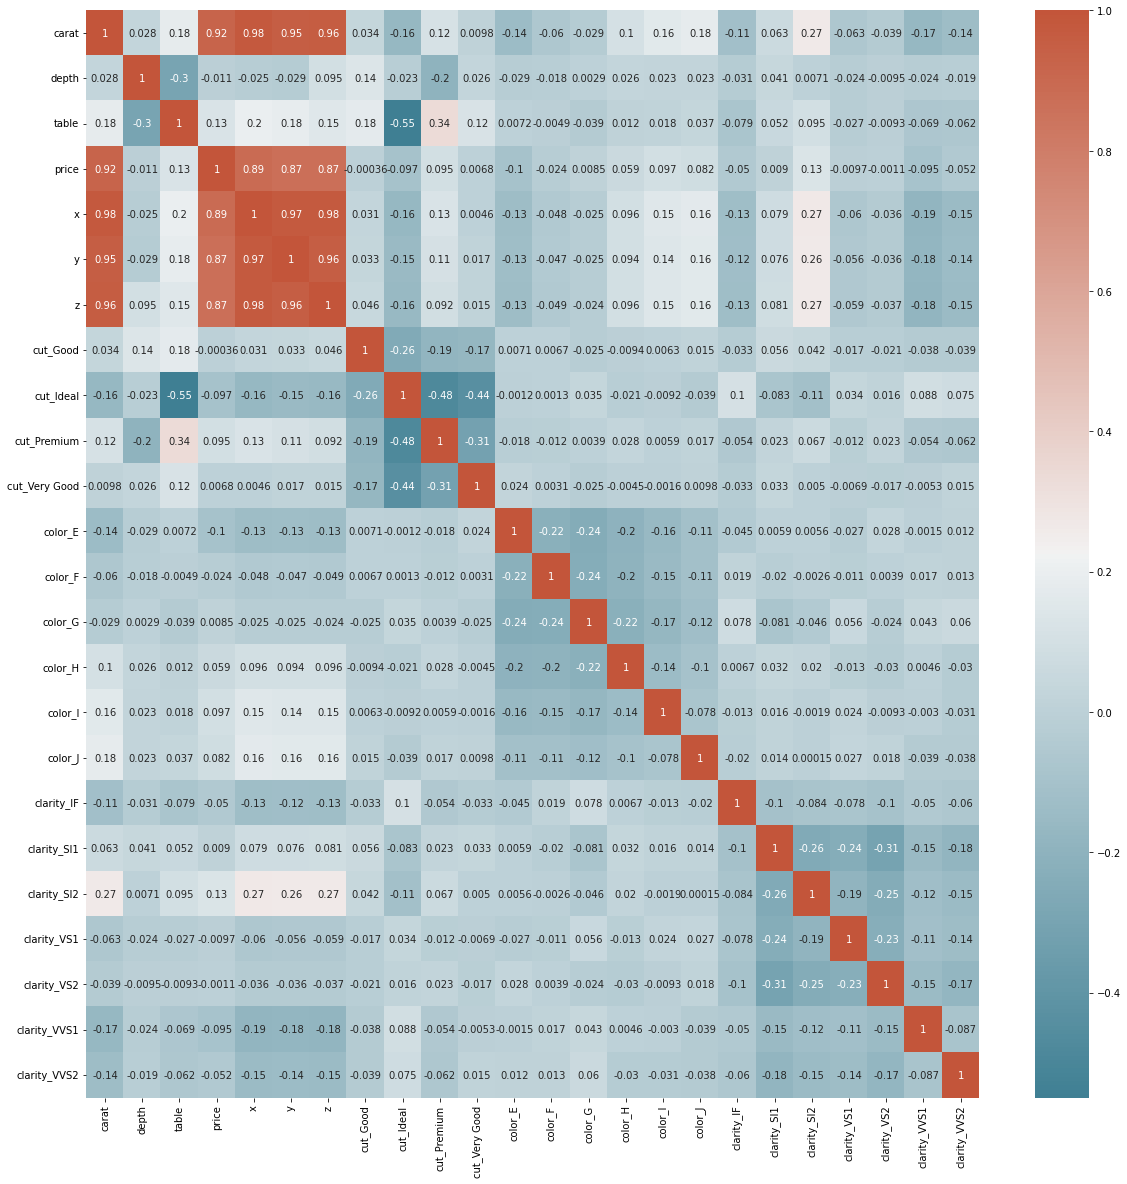

In [ ]:
# Creating a correlation Heat Map for our data
cmap = sns.diverging_palette(220, 20, as_cmap=True)
corrmat= dfCopy.corr()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmat,cmap=cmap,annot=True, )
plt.savefig('heatMap.png',format='png',bbox_inches = "tight")

It can be noted from the above heat map, that there is a strong correlation between the features: **Carat**, **x**, **y**, **z** and our target Price.

On the other hand, there is a weak correlation between the **Depth**, the Cuts: **Cut_Good** and **Cut_Very Good**, all the colors except Colors: **H-J**, and Clarities **VS1/VS2** features and the target Price.

We will explore dropping the weak correlation features later in the feature selection.


# Artificial Neural Network

## Processing data

In [ ]:
# Computing using GPU
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  torch.device("cpu")

# Changing the Price type from int to float
dfCopy['price'] = dfCopy['price'].astype(float)

# Normalizing the data
dfCopy = (dfCopy - dfCopy.min())/(dfCopy.max()-dfCopy.min())

X= dfCopy.loc[:,dfCopy.columns != 'price'].values
y= dfCopy.price.values
X_train2, X_test, y_train2, y_test = train_test_split(X, y,test_size=0.20, random_state=25)

# Creating a Validation set from the training
X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2,test_size=0.20, random_state=25)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

XTrain = torch.from_numpy(X_train)
YTrain = torch.from_numpy(y_train)
XVal = torch.from_numpy(X_val)
YVal = torch.from_numpy(y_val)
XTest = torch.from_numpy(X_test)
YTest = torch.from_numpy(y_test)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(XTrain,YTrain)
validation = torch.utils.data.TensorDataset(XVal,YVal)
test = torch.utils.data.TensorDataset(XTest,YTest)



## The model

In [ ]:
class RegANN(nn.Module):

    def __init__(self, num_inputs, hidden_sizes, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, hidden_sizes[0])
        self.act_fn = nn.ReLU()
        self.hidden = nn.ModuleList()
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
        self.out = nn.Linear(hidden_sizes[-1], num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        # Perform the calculation of the model to determine the prediction
        for layer in self.hidden:
            x = self.act_fn(x)
            x = layer(x)
        
        x = self.act_fn(x)
        x = self.out(x)
        return x

## Optimization

### Train & Test functions

In [ ]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=75):
    loss_list = []
    # Set model to train mode
    model.train() 
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        loss_list_epoch = []
        for data_inputs, data_labels in data_loader:
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float()) 
            loss_list_epoch.append(loss.item())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
        loss_list.append(sum(loss_list_epoch)/len(loss_list_epoch))
    return loss_list

In [ ]:
def test_model(data_loader, model, loss_module):
  
    # Changing model to evaluation mode
    model.eval()
    test_loss = []

    with torch.no_grad():
        for data_inputs, data_labels in data_loader:

            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            pred = model(data_inputs)
            pred = pred.squeeze(dim=1)
            
            test_loss.append(loss_module(pred, data_labels).item())

    return test_loss

### Hyperparameter tuning

In [ ]:
# Hyperparameter tuning
learning_rates = [0.1, 0.01, 0.001]
hidden_layer_cells = [10, 15, 20]
num_layers = [1,2,3]
batch_sizes = [75, 100]

min_loss = float("inf")
argMinLr = 0.1
argMinHlc = 5
argMinBS = 75
argMinNl = 1

# Searching for best Hyper-parameters 
for lr in learning_rates:
  for hlC in hidden_layer_cells:
    for bs in batch_sizes:
      for nl in num_layers:

        train_loader = DataLoader(train, batch_size = bs, shuffle = True)
        valid_loader = DataLoader(validation, batch_size = bs, shuffle = False)
        
        h_sizes = []
        for k in range(nl):
          h_sizes.append(hlC)
        
        model = RegANN(num_inputs=23, hidden_sizes = h_sizes, num_outputs=1)
        model.to(device)
        # Printing a module shows all its submodules
        print(model)
        for name, param in model.named_parameters():
          print(f"Parameter {name}, shape {param.shape}")

        loss_module = nn.MSELoss() 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_model(model, optimizer, train_loader, loss_module)

        validation_loss = test_model(valid_loader, model, loss_module)

        if validation_loss < min_loss:
          print(validation_loss)
          min_loss = validation_loss
          argMinLr = lr
          argMinHlc = hlC
          argMinBS = bs
          argMinNl = nl


RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.004391739303487
0.004391739303487
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.04977309332903603
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter hidden.1.weight, shape torch.Size([10, 10])
Parameter hidden.1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.04572743333169613
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0030059298826916807
0.0030059298826916807
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0019743338129590213
0.0019743338129590213
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter hidden.1.weight, shape torch.Size([10, 10])
Parameter hidden.1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.004387416322876154
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0028177299024938636
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.048291662595523845
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter hidden.1.weight, shape torch.Size([15, 15])
Parameter hidden.1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.004633244981082028
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0030075965433156698
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.046420383727413486
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter hidden.1.weight, shape torch.Size([15, 15])
Parameter hidden.1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.008906394789188072
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.006088689977206804
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.04561188973582767
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter hidden.1.weight, shape torch.Size([20, 20])
Parameter hidden.1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.04622339229260025
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.003455978885143139
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.006780248898049367
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter hidden.1.weight, shape torch.Size([20, 20])
Parameter hidden.1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.046833033084698106
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0011269715009959705
0.0011269715009959705
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010494943543845098
0.0010494943543845098
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter hidden.1.weight, shape torch.Size([10, 10])
Parameter hidden.1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0011306047321152713
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0012303466859123744
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.001048723964660225
0.001048723964660225
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter hidden.1.weight, shape torch.Size([10, 10])
Parameter hidden.1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0015979973577904976
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010202668272540905
0.0010202668272540905
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010191042875421458
0.0010191042875421458
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter hidden.1.weight, shape torch.Size([15, 15])
Parameter hidden.1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010741868862733726
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010225789985437502
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0012675327551283542
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter hidden.1.weight, shape torch.Size([15, 15])
Parameter hidden.1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010764710457952715
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0011869885628553235
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0011028422877957225
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter hidden.1.weight, shape torch.Size([20, 20])
Parameter hidden.1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0009851490540313534
0.0009851490540313534
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.001012498617570997
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.002858180555397238
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter hidden.1.weight, shape torch.Size([20, 20])
Parameter hidden.1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0011455739149823785
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010851624485502694
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010110649156307898
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter hidden.1.weight, shape torch.Size([10, 10])
Parameter hidden.1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.001283754256668356
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0011433219950614047
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0011209066543760228
RegANN(
  (linear1): Linear(in_features=23, out_features=10, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([10, 23])
Parameter linear1.bias, shape torch.Size([10])
Parameter hidden.0.weight, shape torch.Size([10, 10])
Parameter hidden.0.bias, shape torch.Size([10])
Parameter hidden.1.weight, shape torch.Size([10, 10])
Parameter hidden.1.bias, shape torch.Size([10])
Parameter out.weight, shape torch.Size([1, 10])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0009983336518186777
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.001024319132707676
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010096187427828635
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter hidden.1.weight, shape torch.Size([15, 15])
Parameter hidden.1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.000977106409569889
0.000977106409569889
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010999325313605368
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0009978512932958573
RegANN(
  (linear1): Linear(in_features=23, out_features=15, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([15, 23])
Parameter linear1.bias, shape torch.Size([15])
Parameter hidden.0.weight, shape torch.Size([15, 15])
Parameter hidden.0.bias, shape torch.Size([15])
Parameter hidden.1.weight, shape torch.Size([15, 15])
Parameter hidden.1.bias, shape torch.Size([15])
Parameter out.weight, shape torch.Size([1, 15])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0009460979614315832
0.0009460979614315832
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010377396438029948
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0009807346786115446
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter hidden.1.weight, shape torch.Size([20, 20])
Parameter hidden.1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0009849868114668362
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList()
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0010715897162257555
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0009511768829275522
RegANN(
  (linear1): Linear(in_features=23, out_features=20, bias=True)
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([20, 23])
Parameter linear1.bias, shape torch.Size([20])
Parameter hidden.0.weight, shape torch.Size([20, 20])
Parameter hidden.0.bias, shape torch.Size([20])
Parameter hidden.1.weight, shape torch.Size([20, 20])
Parameter hidden.1.bias, shape torch.Size([20])
Parameter out.weight, shape torch.Size([1, 20])
Parameter out.bias, shape torch.Size([1])


  0%|          | 0/75 [00:00<?, ?it/s]

Average MSE loss for the test: 0.0012921128781972688


In [ ]:
# We'll print the best hyperparameters from the above tuning:
print(f"Most optimal Learning Rate: {argMinLr}")
print(f"Most optimal Batch Size: {argMinBS}")
print(f"Most optimal number of neurons in the Hidden Layers: {argMinHlc}")
print(f"Most optimal number of Hidden Layers: {argMinNl}")

Most optimal Learning Rate: 0.001
Most optimal Batch Size: 100
Most optimal number of neurons in the Hidden Layers: 15
Most optimal number of Hidden Layers: 3


### Graphing validation and training loss after tuning

In [ ]:
# Defining a function that will return us the validation and training loss list at once
def train_and_validate(model, optimizer, data_loader, valid_loader, loss_module, num_epochs=75):
    train_loss_list = []
    validation_loss_list = []
    # Set model to train mode
    model.train() 
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        loss_list_epoch = []
        for data_inputs, data_labels in data_loader:
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float()) 
            loss_list_epoch.append(loss.item())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
        train_loss_list.append(sum(loss_list_epoch)/len(loss_list_epoch))
        validation_loss = sum(test_model(valid_loader, model, loss_module))/len(test_model(valid_loader, model, loss_module))
        validation_loss_list.append(validation_loss)
    return [train_loss_list, validation_loss_list]

In [ ]:
# We'll train the model again on these hyperparameters in order to get the parameters for validation:
train_loader = DataLoader(train, batch_size = 100, shuffle = True)
valid_loader = DataLoader(validation, batch_size = 100, shuffle = False)
test_loader = DataLoader(test, batch_size = 100, shuffle = False)

model = RegANN(num_inputs=23, hidden_sizes=[15,15,15], num_outputs=1)
model.to(device)

loss_module = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_list, valid_loss_list = train_and_validate(model, optimizer, train_loader, valid_loader, loss_module)

  0%|          | 0/75 [00:00<?, ?it/s]

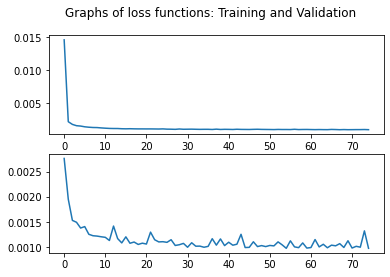

In [ ]:
# Plotting MSE loss For training (on top) and validation (on the bottom)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Graphs of loss functions: Training and Validation')
ax1.plot(train_loss_list)
ax2.plot(valid_loss_list)

In [ ]:
# Testing the model
test_loss_list = test_model(test_loader, model, loss_module)
avg_loss = sum(test_loss_list) / len(test_loss_list)
print(f"MSE loss: {avg_loss}")

MSE loss: 0.0010331666613907415


In [ ]:
# Calculating R2 Score and MAE Loss

preds = torch.Tensor([])
labels = torch.Tensor([])
for data_inputs, data_labels in test_loader:
  ## Step 1: Move input data to device (only strictly necessary if we use GPU)
  data_inputs = data_inputs.to(device)
  labels = torch.cat([labels, data_labels])       

  ## Step 2: Run the model on the input data
  preds_batch = model(data_inputs)
  preds_batch = preds_batch.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
  preds = torch.cat([preds, preds_batch.cpu()])


preds = preds.data
labels = labels.data

print("MAE:", mean_absolute_error(y_test, preds))
print("R2 score:", r2_score(labels, preds))


MAE: 0.017040761
R2 score: 0.9780787941113864


## Regularization

In [ ]:
def train_model_l1_and_l2(model, optimizer, data_loader, valid_loader, loss_module, lambda1, lambda2, num_epochs=75):

    train_loss_list = []
    validation_loss_list = []
    # Set model to train mode
    model.train() 
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        loss_list_epoch = []
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            l1 = 0 
            # Adding the l1 regularization
            for p in model.parameters():
              l1 = l1 + p.abs().sum()
              
            loss = loss + lambda1 * l1
            # Adding the l2 regularization
            l2 = 0 
            # Now let's add the l2 regularization
            for p in model.parameters():
              l2 = l2 + p.pow(2).sum()
            loss = loss + lambda2 * l2

            loss_list_epoch.append(loss.cpu().data)

            ## Step 4: Perform backpropagation
            
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            ## Step 5: Update the parameters
            optimizer.step()
        train_loss_list.append(sum(loss_list_epoch)/len(loss_list_epoch))
        valLoss = test_model(valid_loader, model, loss_module)
        validation_loss = sum(valLoss)/len(valLoss)
        validation_loss_list.append(validation_loss)
    return [train_loss_list, validation_loss_list]

  0%|          | 0/75 [00:00<?, ?it/s]

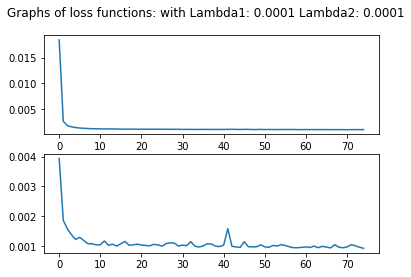

In [ ]:
# Testing the function with different values for the Lambdas
train_loader = DataLoader(train, batch_size = 100, shuffle = True)
valid_loader = DataLoader(validation, batch_size = 100, shuffle = False)
test_loader = DataLoader(test, batch_size = 100, shuffle = False)

model = RegANN(num_inputs=23, hidden_sizes=[15,15,15], num_outputs=1)
model.to(device)
loss_module = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001)

train_loss_list, valid_loss_list = train_model_l1_and_l2(model, optimizer, train_loader, valid_loader, loss_module, 0.000001, 0)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Graphs of loss functions: with Lambda1: 0.0001 Lambda2: 0.0001')
ax1.plot(train_loss_list)
ax2.plot(valid_loss_list)

In [ ]:
# We'll also test the newly trained model
test_loss_list = test_model(test_loader, model, loss_module)
avg_loss = sum(test_loss_list) / len(test_loss_list)
print(f"The average loss on the test of the Neural Network model after Regularization: {avg_loss}")

The average loss on the test of the Neural Network model after Regularization: 0.0010871441398329032


# Linear Regression

In [ ]:
dfCopy['price'] = dfCopy['price'].astype(float)
# Normalizing the data
dfCopy = (dfCopy - dfCopy.min())/(dfCopy.max()-dfCopy.min())

X= dfCopy.loc[:,dfCopy.columns != 'price'].values
Y= dfCopy.price.values
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=25)
linReg =LinearRegression()

# Setting up hyperparameter/function parameters lists for tuning
params = {
    "copy_X": [True, False],
    "positive": [True, False],
    "n_jobs": [None, 1, 2, 3]
}

# Tuning hyperparameters and cross validating
gs_cv = GridSearchCV(linReg, params)

# Training
gs_cv.fit(X_train, y_train)
print("Best params:", gs_cv.best_params_)
print("Best score:", gs_cv.best_score_)

Best params: {'copy_X': True, 'n_jobs': None, 'positive': False}
Best score: 0.9177633653234978


In [ ]:
linReg = LinearRegression(copy_X = True, n_jobs = None, positive = False)
linReg.fit(X_train,y_train)

preds = linReg.predict(X_test)
# We'll test the model
print("R2 score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))

R2 score: 0.8967816260412664
MAE: 0.04044320045360761
MSE: 0.004867695300525574


In [ ]:
# We'll notice that the given result is identical to using the default LinearRegression()
linReg = LinearRegression()
linReg.fit(X_train,y_train)

preds = linReg.predict(X_test)
# We'll test the model
print("R2 score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))

R2 score: 0.8967816260412664
MAE: 0.04044320045360761
MSE: 0.004867695300525574


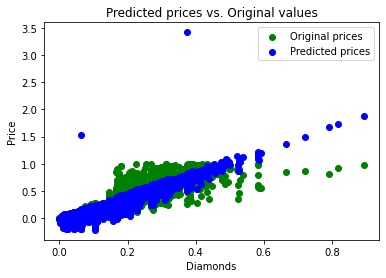

In [ ]:
# Let's plot our Regression line
plt.scatter(X_test[:,0], y_test, label = "Original prices", color = "green")
plt.scatter(X_test[:,0], preds, label = "Predicted prices", color = "blue")
plt.legend()
plt.xlabel("Diamonds")
plt.ylabel("Price")
plt.title("Predicted prices vs. Original values")
plt.show()
# We'll notice the linear shape of the predicted prices.

# Decision Tree Regression

In [ ]:
dfCopy['price'] = dfCopy['price'].astype(float)

# Normalizing the data
dfCopy = (dfCopy - dfCopy.min())/(dfCopy.max()-dfCopy.min())

X= dfCopy.loc[:,dfCopy.columns != 'price'].values
y= dfCopy.price.values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=25)
decTreeReg = DecisionTreeRegressor()

# Setting up hyperparameter lists for tuning
params = {
    "max_depth": [6,8,10,12,14,16], # Maximum depth of the tree
    "max_leaf_nodes": list(range(2,100)),
    "min_samples_split": [2,3,4] # Minimum number of samples to split in an internal node
}

# Tuning hyperparameters and cross validating
gs_cv = GridSearchCV(decTreeReg, params)

# Training
gs_cv.fit(X_train, y_train)
print("Best params:", gs_cv.best_params_)
print("Best score:", gs_cv.best_score_)

Best params: {'max_depth': 14, 'max_leaf_nodes': 99, 'min_samples_split': 2}
Best score: 0.9534059089467775


In [ ]:
# From the above calculation we get the following best hyperparameters:
decTreeReg = DecisionTreeRegressor(max_depth=14, max_leaf_nodes=99, min_samples_split=4)
decTreeReg.fit(X_train,y_train)

preds = decTreeReg.predict(X_test)
# We'll now test the model
print("R2 score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))


R2 score: 0.9533918564817808
MAE: 0.026370013007981752
MSE: 0.0021980024725109576


In [ ]:
# This is a slight Improvement to the default parameters given calling the DecisionTreeRegressor() without adjustment
decTreeRegDefault = DecisionTreeRegressor()
decTreeRegDefault.fit(X_train,y_train)

preds = decTreeRegDefault.predict(X_test)
# We'll now test the model
print("R2 score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))

R2 score: 0.9522638189115089
MAE: 0.021107128300592706
MSE: 0.0022511998148932767


In [ ]:
# Let's disply the decision tree from our calculations:
fig = plt.figure(figsize=(200,200))
tree.plot_tree(decTreeReg, filled=True)
plt.savefig('tree.png',format='png',bbox_inches = "tight")

# Random Forest Regression

In [ ]:
dfCopy['price'] = dfCopy['price'].astype(float)

# Normalizing the data
dfCopy = (dfCopy - dfCopy.min())/(dfCopy.max()-dfCopy.min())

X= dfCopy.loc[:,dfCopy.columns != 'price'].values
y= dfCopy.price.values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=25)
RanForestReg = RandomForestRegressor()

# Setting up hyperparameter lists for tuning
params = {
    "max_features": ['auto', 'sqrt'], # Number of features in consideration at every split
    "n_estimators": [5,20,50,100], # The number of trees in the forest
    "min_samples_split": [2, 6, 10], # Minimum number of samples to split in an internal node
    "min_samples_leaf": [1, 3, 4] # Minimum sample number that can be stored in a leaf node
}

# Tuning hyperparameters and cross validating
gs_cv = GridSearchCV(RanForestReg, params)

# Training
gs_cv.fit(X_train, y_train)
print("Best params:", gs_cv.best_params_)
print("Best score:", gs_cv.best_score_)

Best params: {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9736716792940076


In [ ]:
# Let's apply the hyperparameters
RanForestReg = RandomForestRegressor(max_features= 'auto', min_samples_split=2, min_samples_leaf = 1, n_estimators=100)
RanForestReg.fit(X_train,y_train)

preds = RanForestReg.predict(X_test)
# We'll now test the model
print("R2 score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))


R2 score: 0.9749021133261915
MAE: 0.01613269253007221
MSE: 0.0011835961014466684


# K-Nearest Neighbors Regression

In [ ]:
dfCopy['price'] = dfCopy['price'].astype(float)

# Normalizing the data
dfCopy = (dfCopy - dfCopy.min())/(dfCopy.max()-dfCopy.min())

X= dfCopy.loc[:,dfCopy.columns != 'price'].values
y= dfCopy.price.values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=25)
KNeighReg = KNeighborsRegressor()

# Setting up hyperparameter lists for tuning
params = {
    "leaf_size": list(range(1,50)),
    "n_neighbors": list(range(1,20)), # Number of neighbors (value of k)
    "p": [1,2] # Power parameter for the Minkowski metric.
}

# Tuning hyperparameters and cross validation
gs_cv = RandomizedSearchCV(KNeighReg, params)

# Training
gs_cv.fit(X_train, y_train)
print("Best params:", gs_cv.best_params_)
print("Best score:", gs_cv.best_score_)

Best params: {'p': 2, 'n_neighbors': 2, 'leaf_size': 11}
Best score: 0.9619452480598805


In [ ]:
# Let's apply the hyperparameters
KNeighReg = KNeighborsRegressor(leaf_size = 11, n_neighbors = 2, p = 2)
KNeighReg.fit(X_train,y_train)

preds = KNeighReg.predict(X_test)
# We'll now test the model
print("R2 score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))


R2 score: 0.9634311343852464
MAE: 0.02059501959897579
MSE: 0.0017245582203189304


In [ ]:
# This is an improvement to the default parameters given calling the KNeighborsRegressor() without adjustment
KNeighReg = KNeighborsRegressor()
KNeighReg.fit(X_train,y_train)

preds = KNeighReg.predict(X_test)
# We'll now test the model
print("R2 score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))

R2 score: 0.9618925047800848
MAE: 0.02010969097723602
MSE: 0.0017971187520445


# Feature Selection

In [ ]:
dfCopy2 = df.copy()
# Removing 0 values
dfCopy2 = dfCopy2.drop(dfCopy2[dfCopy2["x"]==0].index)
dfCopy2 = dfCopy2.drop(dfCopy2[dfCopy2["y"]==0].index)
dfCopy2 = dfCopy2.drop(dfCopy2[dfCopy2["z"]==0].index)

dfCopy2['price'] = dfCopy2['price'].astype(float)
dfCopy2 = pd.get_dummies(dfCopy2,drop_first=True)
dfCopy2 = dfCopy2.drop(['depth', 'cut_Good', 'cut_Very Good', 'color_E','color_F','color_G', 'clarity_VS1', 'clarity_VS2'], axis=1)

# Normalizing the data
dfCopy2 = (dfCopy2 - dfCopy2.min())/(dfCopy2.max()-dfCopy2.min())

X= dfCopy2.loc[:,dfCopy2.columns != 'price'].values
y= dfCopy2.price.values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=25)


In [ ]:
# Now we'll train the code on the most accurate model we built - RandomForest with the tuned parameters and hyperparameters.
RanForestReg = RandomForestRegressor(max_features= 'auto', min_samples_split=2, min_samples_leaf = 1, n_estimators=100)
RanForestReg.fit(X_train,y_train)

# Cross Validation
cv_score = cross_val_score(RanForestReg, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
cv_score = sum(cv_score)/len(cv_score)
print(f"Cross validation score: {cv_score}")

preds = RanForestReg.predict(X_test)

# Testing the model
print("R2 score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))


Cross validation score: -0.043721159037625454
R2 score: 0.9565177590212639
MAE: 0.021498205986100388
MSE: 0.002050587428873223


The R2 score of our RandomForest model after feature selection only decreased by a little bit.